In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

In [18]:
# Define paths
train_dir = 'dataset/Train'
valid_dir = 'dataset/Validation'
test_dir = 'dataset/Test'

In [19]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=64,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(100, 100),
    batch_size=64,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 235412 images belonging to 2 classes.
Found 39610 images belonging to 2 classes.
Found 20201 images belonging to 2 classes.


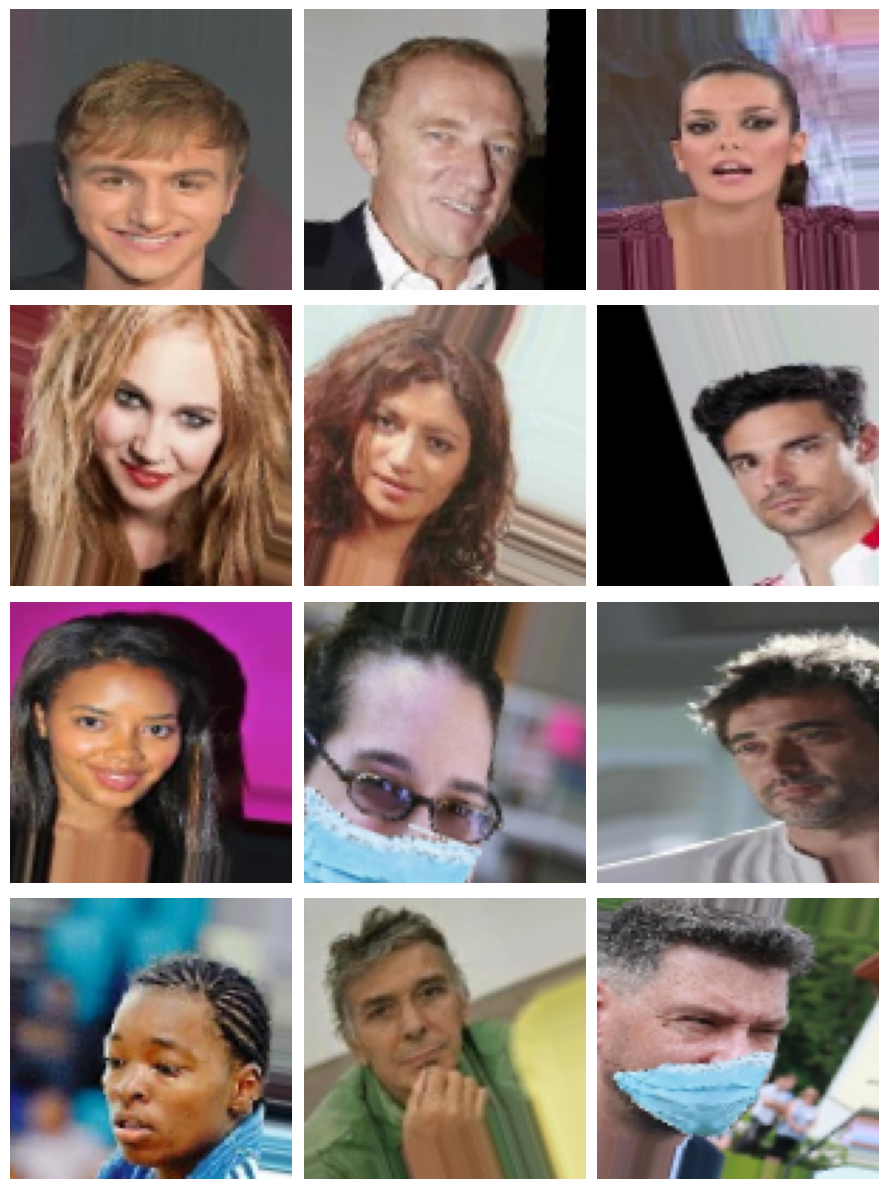

In [20]:
# pull batch of img from train_generator
x_batch, y_batch = next(train_generator)

# random 12 images from batch
num_samples = 12
random_indices = np.random.choice(len(x_batch), num_samples, replace=False)
selected_images = x_batch[random_indices]

fig, axes = plt.subplots(4, 3, figsize=(9, 12))  # 4 row × 3 column

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])  # Show random images
    ax.axis('off') 

plt.tight_layout()
plt.show()

In [21]:
# Build Input Layer
input_layer = Input(shape=(100, 100, 3))

# Block 1
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# Block 2
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# Block 3
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Build model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_13 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 batch_normalization_14 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0   

In [22]:
# Set Callback
checkpoint = ModelCheckpoint(
    "GenderModel-Pro.keras",          
    monitor="val_accuracy",    
    save_best_only=True,     
    mode="max",               
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",       
    patience=25,              
    mode="max",               
    restore_best_weights=True 
)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=50,  
    callbacks=[checkpoint, early_stopping] 
)

Epoch 1/50
3678/3678 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.7753     
Epoch 1: val_accuracy improved from -inf to 0.86056, saving model to GenderModel-Pro.keras
3678/3678 [==============================] - 434s 118ms/step - loss: 0.4492 - accuracy: 0.7753 - val_loss: 0.3069 - val_accuracy: 0.8606
Epoch 2/50
3678/3678 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9119   
Epoch 2: val_accuracy improved from 0.86056 to 0.92347, saving model to GenderModel-Pro.keras
3678/3678 [==============================] - 384s 104ms/step - loss: 0.2197 - accuracy: 0.9119 - val_loss: 0.1802 - val_accuracy: 0.9235
Epoch 3/50
3678/3678 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9321  
Epoch 3: val_accuracy improved from 0.92347 to 0.94289, saving model to GenderModel-Pro.keras
3678/3678 [==============================] - 390s 106ms/step - loss: 0.1747 - accuracy: 0.9321 - val_loss: 0.1704 - val_accuracy: 0.9429
Epoch 

In [24]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Predict the test data
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_report = classification_report(test_generator.classes, y_pred, target_names=['Male', 'Female'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

316/316 [==============================] - 11s 35ms/step - loss: 0.0393 - accuracy: 0.9857
Test accuracy: 0.9857432842254639
316/316 [==============================] - 9s 30ms/step
Confusion Matrix:
[[11476   166]
 [  122  8437]]

Classification Report:
              precision    recall  f1-score   support

        Male       0.99      0.99      0.99     11642
      Female       0.98      0.99      0.98      8559

    accuracy                           0.99     20201
   macro avg       0.99      0.99      0.99     20201
weighted avg       0.99      0.99      0.99     20201



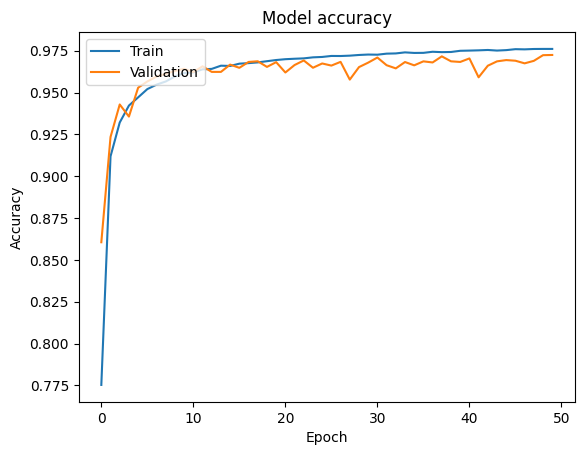

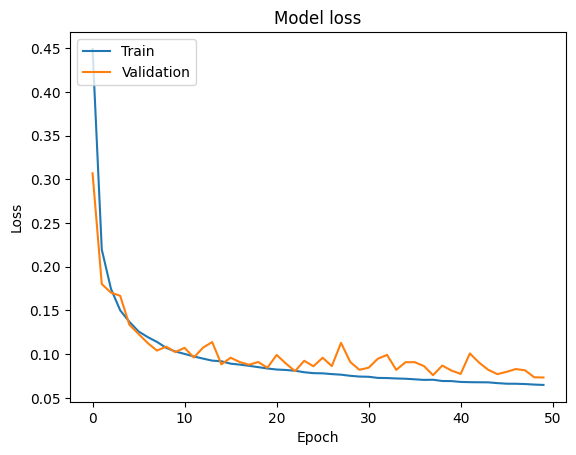

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 138ms/step


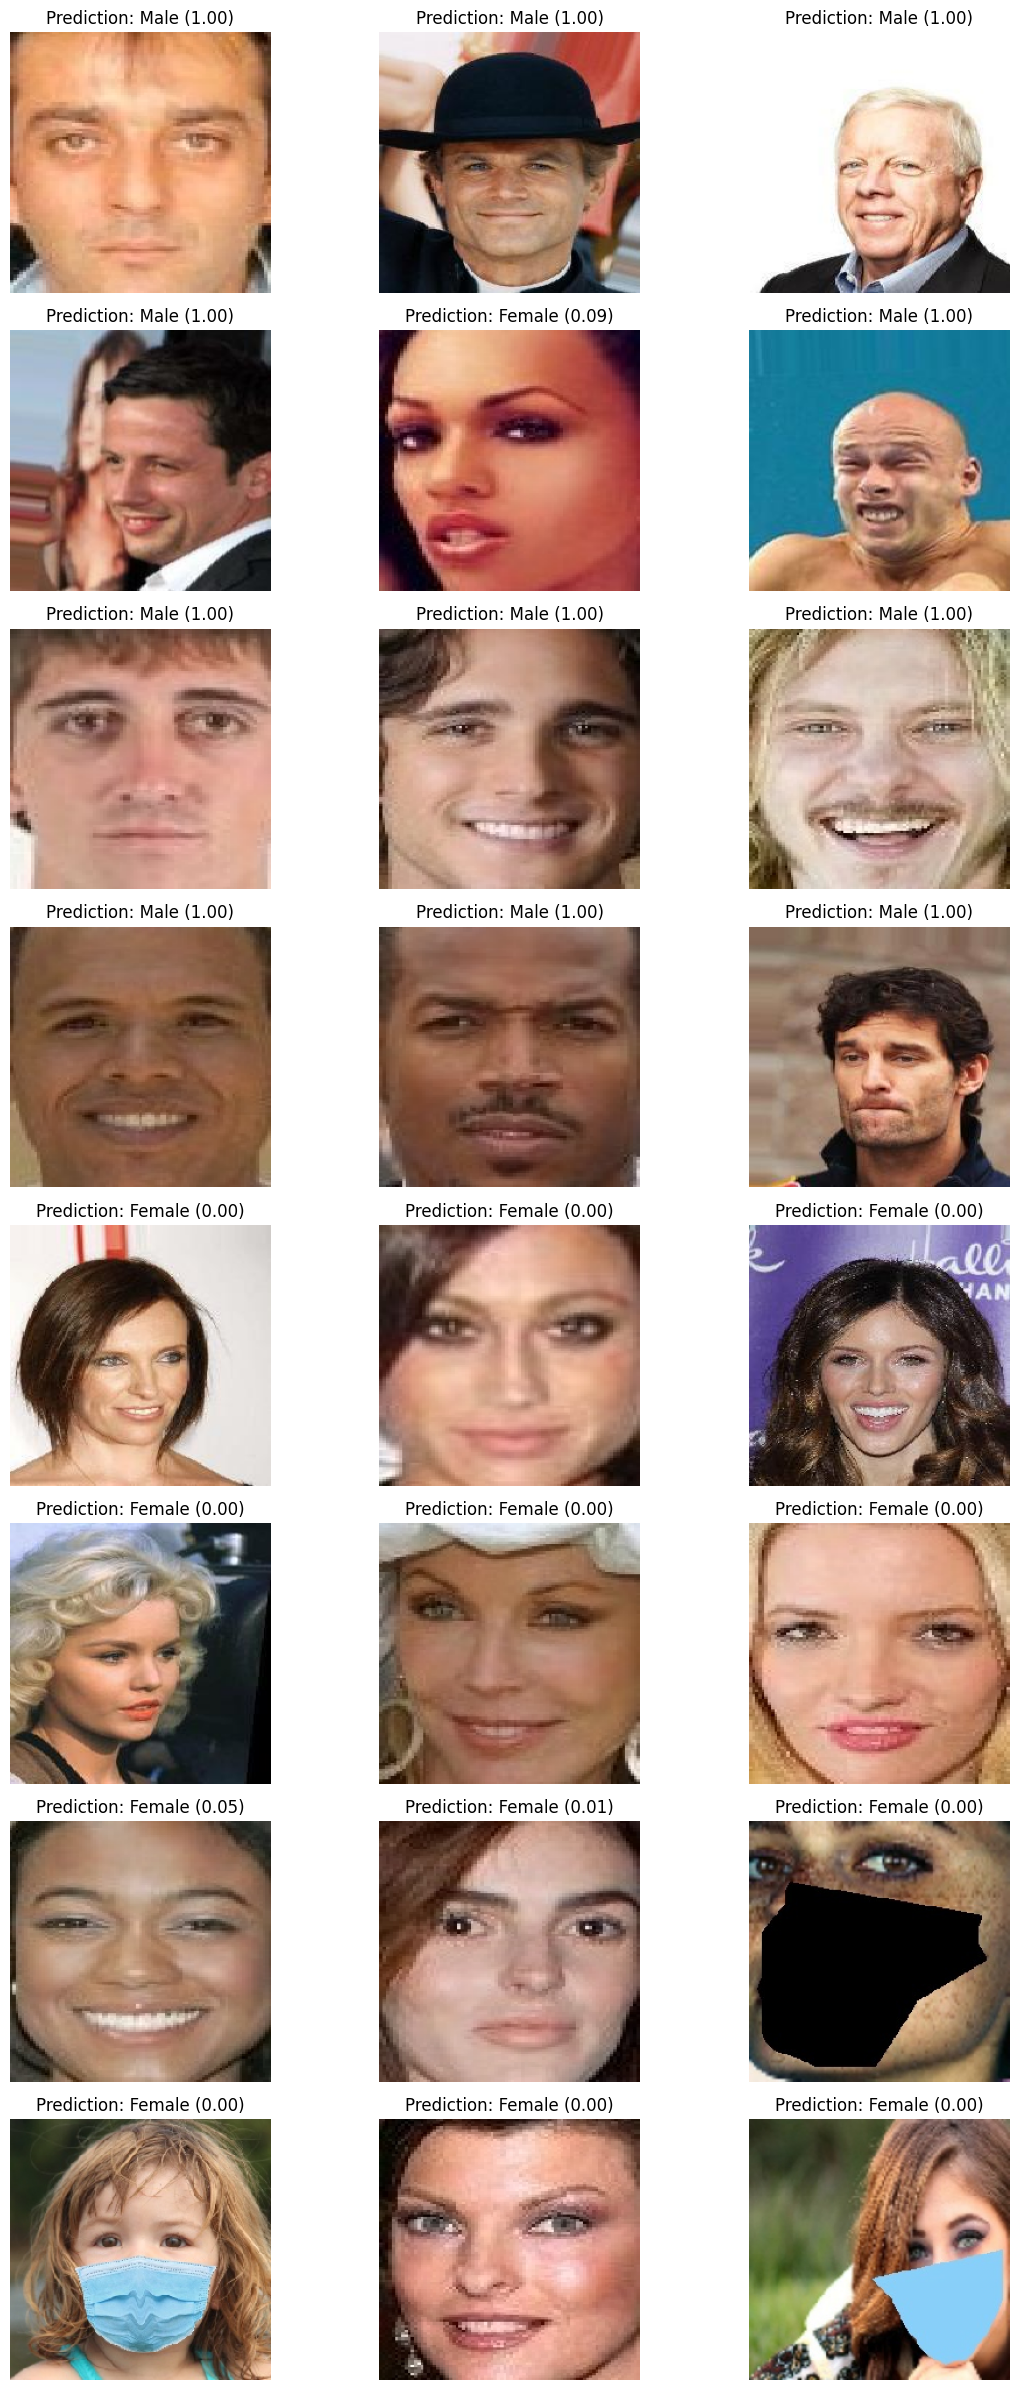

In [26]:
import random

# Define directory paths
valid_dir = 'dataset/Validation'

# Data preparation
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Load and predicted images
def predict_images(model, image_paths):
    images = []
    for img_path in image_paths:
        img_array = prepare_image(img_path)
        images.append(img_array)
    
    images = np.vstack(images)
    predictions = model.predict(images)
    return predictions

# load saved moel
model = tf.keras.models.load_model('model/GenderModel-Pro.keras')

# load images from folder Male and Female
male_dir = os.path.join(valid_dir, 'Male')
female_dir = os.path.join(valid_dir, 'Female')

male_images = os.listdir(male_dir)
female_images = os.listdir(female_dir)

# random pick up images from Male and Female then show 12 images per folder
male_images_sample = random.sample(male_images, 12)
female_images_sample = random.sample(female_images, 12)

# build path for all images
male_image_paths = [os.path.join(male_dir, img_name) for img_name in male_images_sample]
female_image_paths = [os.path.join(female_dir, img_name) for img_name in female_images_sample]

image_paths = male_image_paths + female_image_paths

# predicted
predictions = predict_images(model, image_paths)

# results
fig, axs = plt.subplots(8, 3, figsize=(12, 24)) 
axs = axs.ravel()

for i in range(len(image_paths)):
    img = image.load_img(image_paths[i], target_size=(224, 224))
    axs[i].imshow(img)
    axs[i].axis('off')
    
    # (0 = Male, 1 = Female)
    prediction = predictions[i]
    label = 'Male' if prediction > 0.5 else 'Female'
    axs[i].set_title(f'Prediction: {label} ({prediction[0]:.2f})')

plt.tight_layout()
plt.show()